# DOODL DEMO

In [1]:
from doodl import gen
from PIL import Image
! mkdir ims

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loaded all models
Using torch float16, if need more precision need to change custom_fwd
mkdir: cannot create directory ‘ims’: File exists


This notebook demos the various types of guidance used in our paper. Each function will sequentially optimize and image, saving iteratively to `ims/`. Because our optimization uses momentum, it generally takes 10+ steps for significant change to occur. For 50 DDIM steps, an optimization step will be performed approximately once a minute.

The aesthetic editing works fairly robustly with failure modes primary being from image corruption (loss of subject matter due to lack of text conditioning). Personalization consistency is as described in the paper/supplementary; approximately half the time on a challenging problem. FGVC and CLIP are both distributional; generally they outperform the baseline generation by a large margin but results are class/text dependent and can vary between seeds.

**NOTE**: Due to different types of conditioning requiring loading different models onto the GPU, not all cells in this notebook can be run sequentially without OOMing on a 40GB A100. Generally run the top cell and then whichever function you want to call

 # Aesthetic Editing

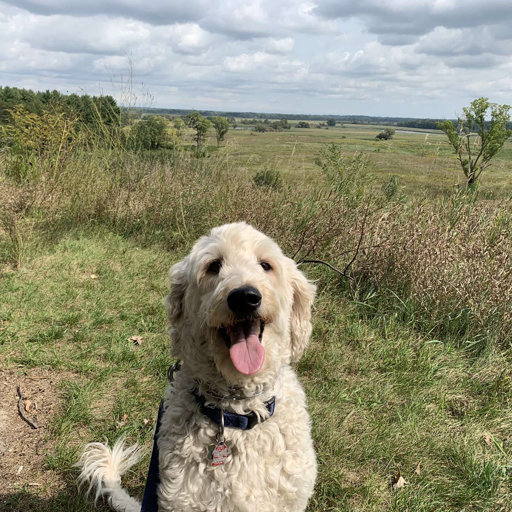

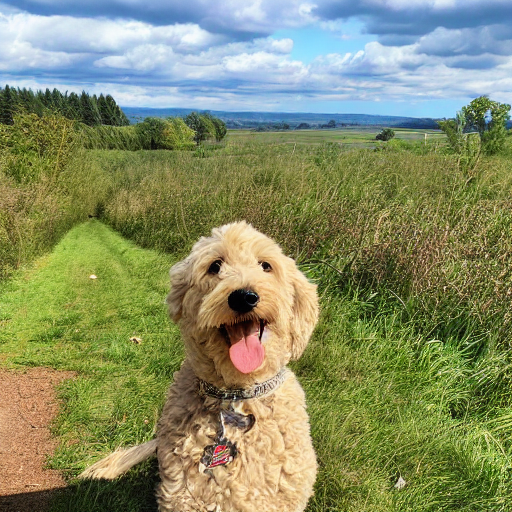

In [2]:
# Before/after below optimization call



def center_crop(im): # PIL center_crop
    width, height = im.size   # Get dimensions
    min_dim = min(width, height)
    left = (width - min_dim)/2
    top = (height - min_dim)/2
    right = (width + min_dim)/2
    bottom = (height + min_dim)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    return im


orig_img = 'example_ims/kona.jpg'
edited_img = 'example_ims/kona_aesthetic.png'
display(center_crop(Image.open(orig_img)).resize((512, 512)))
display(Image.open(edited_img))

In [3]:
source_im = 'example_ims/kona.jpg'
gen('',
    model_guidance_type='aesthetic',
    model_guidance_dict={'aesthetic_target':10, 'clip_model_str':'both', 'weights':[0.5, 1.5]}, 
    grad_scale=1,
    save_str='aesthetic.png',
    renormalize_latents=False,
    perturb_grad_scale=0,
    tied_latents=False,
    num_traversal_steps=25,
    source_im=source_im,
    )

  0%|          | 0/50 [00:00<?, ?it/s]

Optimization Step 0


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization Step 1


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization Step 2


  0%|          | 0/50 [00:00<?, ?it/s]

Optimization Step 3


  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Personalization

In [ ]:
source_im = 'example_ims/imagenet_dog_4.jpg'
Image.open(source_im)

In [ ]:
# As noted in the paper, this takes a VERY long time. >100 optimization steps --> multiple hours
prompt = "A dog wearing sunglasses"
seed = 0
gen(prompt,
    model_guidance_type='CLIP',
    model_guidance_dict={'clip_viz_paths':[source_im],
                         'clip_model_str':'all',
                         'weights':[1.5, 0.5, 0.5]},
    grad_scale=3,
    save_str='personalization.png',
    seed=seed,
    cut_power=0.06, 
    perturb_grad_scale=0,
    clip_grad_val=3e-3,
    num_traversal_steps=500,
    )


# Basic Text Reinforcement

In [ ]:
prompt = 'Darth Vader playing with raccoon on Mars during sunset.'
seed = 0
gs = 1
gen(prompt,
    model_guidance_type='CLIP',
    model_guidance_dict={'clip_prompt':prompt},
    grad_scale=gs,
    seed=seed,
    latent_seed=seed,
    save_str='clip_text.png',
    )

# FGVC (Dogs)

In [ ]:
prompt = 'A Brabancon Griffon, a type of dog'
seed = 1 # 0 is already pretty successful
gs = 0.05

gen(prompt,
    model_guidance_type='fgvc',
    model_guidance_dict={'class':110, 'dataset':'dog'},
    grad_scale=gs,
    seed=seed,
    latent_seed=seed,
    save_str='fgvc_dog.png',
    clip_grad_val=1e-2,
    perturb_grad_scale=1e-3,
    save_interval=1)

# Symmetry

In [ ]:
# Example of better symmetry from below
print("original generation")
display(Image.open('example_ims/symmetry_0.png'))
print("DOODL-optimized generation")
display(Image.open('example_ims/symmetry_49.png'))

In [ ]:
# Not included in our paper, but an example of a simple loss calculation that can be incorporated
seed = 0
gen('A symmetric stained glass window',
    model_guidance_type='symmetry',
    save_str='symmetry.png',
    seed=seed,
    latent_seed=seed,
    )